# Analysis

In [1]:
%load_ext autoreload
%autoreload 2
from utils import dpo_dependencies
from utils import base_dependencies
import random
import pandas as pd
import numpy as np
import shutil
import pandas as pd
from itertools import combinations
import json
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
winning_pair_path = 'outputs/dpo/dpo_final_pairs/human_50/winning_pairs.jsonl'
final50 = pd.read_json(winning_pair_path, lines=True)
orig_w_success_dict = final50.groupby("original")["factor"].apply(set).to_dict()
final50orig = set([key for key, value in orig_w_success_dict.items() if len(orig_w_success_dict[key]) == 6])
final50 = final50[final50['original'].isin(final50orig)]
final50['simp1_wc'] = base_dependencies.wcs(list(final50['simp1']))
final50['simp2_wc'] = base_dependencies.wcs(list(final50['simp2']))
final50['wc_diff'] = np.abs(final50['simp1_wc'] - final50['simp2_wc'])
final50 = final50.sort_values(['wc_diff'], ascending=False)
drop = final50[0:7]['original'].unique()
final50 = final50[~final50['original'].isin(drop)]

In [3]:
test_sentences = pd.DataFrame(base_dependencies.load_jsonl(f'data/sft_holdout.jsonl'))
test_sentences['orig_id'] = list(test_sentences.index)
test_sentences['orig_id'] = 'uid_apa_test_' + test_sentences.index.astype(str)
test_sentences[['original', 'orig_id', 'prompt']]

total_possible_pairs = pd.read_json('outputs/dpo/dpo_final_pairs/human_50/final_possible_pairs.json', lines=True)
total_possible_pairs.rename(columns={'generation_1':'simp1', 'generation_2':'simp2'}, inplace=True)
tmp = pd.merge(left=final50, right=total_possible_pairs, on=['original', 'simp1', 'simp2'])
tmp = tmp[['original', 'simp1', 'simp2', 'factor', 'info_equality', 'wc_diff', 'backbone', 'group_1', 'group_2']]
tmp = tmp.sample(frac=1)
tmp['userGroup'] = tmp.apply(lambda row: 'ea' if 'ea' in row['group_1'] or 'ea' in row['group_2'] else 'ta', axis=1)
tmp = tmp.rename(columns={'simp1': 'simplification1', 'simp2': 'simplification2', 'factor':'question', 'wc_diff':'answer'})
tmp = pd.merge(tmp, test_sentences, how='left', on='original')
tmp = tmp[['prompt', 'original', 'simplification1', 'simplification2', 'question', 'info_equality', 'answer', 'backbone', 'group_1', 'group_2', 'userGroup', 'orig_id']]
tmp['simp_pair_id'] = 'r3_pid_apa' + tmp.index.astype(str)
tmp.to_json('outputs/dpo/dpo_final_pairs/eval_pairs_w_metadata.jsonl', orient='records', lines=True)
tmp = tmp.rename(columns={'info_equality':'options'})

#### analysis

In [4]:
final50 = pd.read_json('outputs/dpo/dpo_final_pairs/eval_pairs_w_metadata.jsonl', lines=True)

In [22]:
import pandas as pd

eval_pairs_w_metadata = pd.read_json('outputs/dpo/dpo_final_pairs/eval_pairs_w_metadata.jsonl', lines=True)
eval_pairs_w_metadata = eval_pairs_w_metadata[['original', 'simplification1', 'simplification2', 'group_1', 'group_2', 'simp_pair_id', 'backbone']]
annos_raw = dpo_dependencies.collect_annotations("anno")
tmp = pd.merge(annos_raw, eval_pairs_w_metadata, how='left', on=['original', 'simplification1', 'simplification2', 'simp_pair_id'])

tmp.loc[(tmp['group_1'] == 'sft') & (tmp['group_2'].str.contains('ea')), 'group_1'] = 'sft_ea'
tmp.loc[(tmp['group_2'] == 'sft') & (tmp['group_1'].str.contains('ea')), 'group_2'] = 'sft_ea'
tmp.loc[(tmp['group_1'] == 'sft') & (tmp['group_2'].str.contains('ta')), 'group_1'] = 'sft_ta'
tmp.loc[(tmp['group_2'] == 'sft') & (tmp['group_1'].str.contains('ta')), 'group_2'] = 'sft_ta'

tmp["winner"] = tmp["group_1"].where(tmp["preference"] == "Vereinfachung 1", tmp["group_2"])
tmp = tmp[tmp['simp_pair_id'].str.contains('r3')]
tmp = tmp[~tmp['preference'].isna()]
tmp_summ = tmp.groupby(['userID', 'backbone'])['winner'].value_counts()
tmp_summ = tmp_summ.reset_index(name='count')

44867


In [2]:
annos_raw = dpo_dependencies.collect_annotations("anno")
annos_raw

44867


,userID,raw_preference,filename,timestamp,raw_perplexity1,raw_perplexity2,id,original,raw_simplification1,raw_simplification2,...,latest_timestamp_by_day,simp_pair_id,ordering,info_equality,perplexity1,perplexity2,simplification1,simplification2,preference,issue
0,ea01,Vereinfachung 2,labeled_ea01_anno_A_2024-12-13-15-01-01.jsonl,2024-12-13 15:01:01,1.1884009533,1.3102807461,pilot_capito_14321,NaN,"Alle Praktika und Studienaufenthalte, die du b...","Alle Praktika und Studien, die du schon mit Er...",...,2024-12-13 15:32:55,pilot_capito_14321,NaN,NaN,1.1884009533,1.3102807461,"Alle Praktika und Studienaufenthalte, die du b...","Alle Praktika und Studien, die du schon mit Er...",Vereinfachung 2,n
1,ea01,Vereinfachung 1,labeled_ea01_anno_A_2024-12-13-15-01-01.jsonl,2024-12-13 15:01:01,1.2812420753,1.1146062522,pilot_capito_25700,NaN,"Und sie wissen nicht, wie viel Arbeit die Mens...","Und sie wissen nicht, wie schwer die Menschen ...",...,2024-12-13 15:32:55,pilot_capito_25700,NaN,NaN,1.2812420753,1.1146062522,"Und sie wissen nicht, wie viel Arbeit die Mens...","Und sie wissen nicht, wie schwer die Menschen ...",Vereinfachung 1,n
2,ea01,Vereinfachung 1,labeled_ea01_anno_A_2024-12-13-15-01-01.jsonl,2024-12-13 15:01:01,1.1576243917,1.089936633,pilot_capito_16233,NaN,Am Anfang arbeiten viele Leute aus der Schweiz...,Am Anfang arbeiten viele Menschen aus der Schw...,...,2024-12-13 15:32:55,pilot_capito_16233,NaN,NaN,1.1576243917,1.089936633,Am Anfang arbeiten viele Leute aus der Schweiz...,Am Anfang arbeiten viele Menschen aus der Schw...,Vereinfachung 1,n
3,ea01,Vereinfachung 1,labeled_ea01_anno_A_2024-12-13-15-01-01.jsonl,2024-12-13 15:01:01,1.2929908476,1.5011290898,pilot_capito_11564,NaN,Bei neuen Ausschreibungen für Buslinien gewann...,Bei neuen Ausschreibungen für Buslinien gewann...,...,2024-12-13 15:32:55,pilot_capito_11564,NaN,NaN,1.2929908476,1.5011290898,Bei neuen Ausschreibungen für Buslinien gewann...,Bei neuen Ausschreibungen für Buslinien gewann...,Vereinfachung 1,n
4,ea01,Vereinfachung 1,labeled_ea01_anno_A_2024-12-13-15-01-01.jsonl,2024-12-13 15:01:01,1.271159651,1.1712958056,pilot_capito_52045,NaN,Wenn jemand ohne Ausweisschild in unserer Firm...,Wenn jemand ohne Ausweis in unserem Betrieb is...,...,2024-12-13 15:32:55,pilot_capito_52045,NaN,NaN,1.271159651,1.1712958056,Wenn jemand ohne Ausweisschild in unserer Firm...,Wenn jemand ohne Ausweis in unserem Betrieb is...,Vereinfachung 1,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45120,ta01,Vereinfachung 1,REDUNDANT_labeled_ta01_anno_B_2024-12-11-12-11...,2024-12-11 12:11:10,1.8119825966,1.4882561527,pilot_capito_59819,NaN,Wenn das Sozialversicherungssystem mehr Geld h...,Wenn der Staat mehr Geld einnimmt als er ausgi...,...,2024-12-11 12:11:10,pilot_capito_59819,NaN,NaN,1.8119825966,1.4882561527,Wenn das Sozialversicherungssystem mehr Geld h...,Wenn der Staat mehr Geld einnimmt als er ausgi...,Vereinfachung 1,n
45121,ta01,Vereinfachung 2,REDUNDANT_labeled_ta01_anno_B_2024-12-11-12-11...,2024-12-11 12:11:10,1.0705429103,1.5035568719,pilot_capito_29975,NaN,Von 1940 bis 1941 töteten die Nazis 70.000 kra...,Zwischen 1940 und 1941 töteten die Nazis viele...,...,2024-12-11 12:11:10,pilot_capito_29975,NaN,NaN,1.0705429103,1.5035568719,Von 1940 bis 1941 töteten die Nazis 70.000 kra...,Zwischen 1940 und 1941 töteten die Nazis viele...,Vereinfachung 2,n
45122,ta01,Vereinfachung 1,REDUNDANT_labeled_ta01_anno_B_2024-12-11-12-11...,2024-12-11 12:11:10,1.2135617771,1.2192665041,pilot_apa_3385,NaN,Die USA haben eine Rakete abgefeuert und dabei...,Ein Raketenangriff der USA hat einen wichtigen...,...,2024-12-11 12:11:10,pilot_apa_3385,NaN,NaN,1.2135617771,1.2192665041,Die USA haben eine Rakete abgefeuert und dabei...,Ein Raketenangriff der USA hat einen wichtigen...,Vereinfachung 1,n
45123,ta01,Vereinfachung 2,REDUNDANT_labeled_ta01_anno_B_2024-12-11-12-11...,2024-12-11 12:11:10,1.3621648695,1.4283146075,pilot_capito_24421,NaN,"Wenn Sie G

In [11]:
tmp = annos_raw[~annos_raw['preference'].isna()]
tmp = tmp.drop_duplicates(subset=['userID', 'day'])
tmp = tmp[tmp['userID'].str.contains('ta')]
tmp = tmp[['userID', 'day']]
tmp.groupby('day')['userID'].count()

day
2024-12-11     1
2024-12-18     1
2025-01-29     9
2025-02-12     9
2025-02-19    10
2025-03-10     6
2025-03-12     6
2025-03-13     5
2025-03-17     7
2025-03-18     8
2025-03-20     8
2025-03-24     8
2025-04-03     6
2025-04-07     6
2025-04-09     2
2025-04-10     3
2025-04-14     1
Name: userID, dtype: int64

In [ ]:
import scipy.stats
np.random.seed(5)
tmp_long = tmp[tmp['userID'].isin(['ea01', 'ea02', 'ea03', 'ea04'])] #, 
for model in tmp_long['backbone'].unique():
    tmp_stattest = tmp_long[tmp_long['backbone'] == model]
    tmp_stattest = tmp_stattest.groupby(['simp_pair_id'])['winner'].value_counts()
    tmp_stattest = tmp_stattest.reset_index(name='count')
    tmp_stattest = tmp_stattest[tmp_stattest['winner'].str.contains('dpo')]
    #tmp_stattest.loc[tmp_stattest['count'] == 2, 'count'] = np.random.choice([1, 3], size=(tmp_stattest['count'] == 2).sum())
    #even_split = len(tmp_stattest[tmp_stattest['count'] == 2])
    print(tmp_stattest['count'].value_counts())
    even_split = 0
    tmp_stattest = tmp_stattest[tmp_stattest['count'] > 2]
    num_dpo = len(tmp_stattest)
    binomtest = scipy.stats.binomtest(num_dpo, n=50-even_split, p=0.5, alternative='greater')
    print(model, binomtest.pvalue)

2    19
3    13
1    11
Name: count, dtype: int64
leolm 0.03245432353613609
3    16
2    14
1     9
Name: count, dtype: int64
llama 0.10131937553227033
3    20
2    19
1     9
Name: count, dtype: int64
disco 4.5107450535653015e-05


In [37]:
import scipy.stats
tmp_long = tmp[tmp['userID'].isin(['ta04', 'ta05', 'ta10', 'ta12'])] # 'ta10'
for model in tmp_long['backbone'].unique():
    tmp_stattest = tmp_long[tmp_long['backbone'] == model]
    tmp_stattest = tmp_stattest.groupby(['simp_pair_id'])['winner'].value_counts()
    tmp_stattest = tmp_stattest.reset_index(name='count')
    tmp_stattest = tmp_stattest[tmp_stattest['winner'].str.contains('dpo')]
    tmp_stattest.loc[tmp_stattest['count'] == 2, 'count'] = np.random.choice([1, 3], size=(tmp_stattest['count'] == 2).sum())
    #even_split = len(tmp_stattest[tmp_stattest['count'] == 2])
    #even_split = 0
    tmp_stattest = tmp_stattest[tmp_stattest['count'] > 2]
    num_dpo = len(tmp_stattest)
    binomtest = scipy.stats.binomtest(num_dpo, n=50-even_split, p=0.5, alternative='two-sided')
    print(model, binomtest.pvalue)

llama 0.032839137564268484
disco 0.887724827340783
leolm 0.6718110337653656


In [23]:
tmp_summ.groupby(['userID'])['count'].sum()

userID
ea01    150
ea02    150
ea03    150
ea04    150
ta01    300
ta03     96
ta04    150
ta05    198
ta07    183
ta10    182
ta11     23
ta12    215
Name: count, dtype: int64

In [25]:
tmp_esumm = tmp_summ[tmp_summ['userID'].isin(['ea01', 'ea02', 'ea03', 'ea04'])]
tmp_esumm = tmp_esumm[tmp_esumm['winner'].str.contains('dpo')]
tmp_esumm

,userID,backbone,winner,count
0,ea01,disco,dpo_ea,37
2,ea01,leolm,dpo_ea,34
4,ea01,llama,dpo_ea,30
7,ea02,disco,dpo_ea,23
9,ea02,leolm,dpo_ea,22
11,ea02,llama,dpo_ea,15
12,ea03,disco,dpo_ea,34
14,ea03,leolm,dpo_ea,26
16,ea03,llama,dpo_ea,27
18,ea04,disco,dpo_ea,36


In [28]:
tmp_tsumm = tmp_summ[tmp_summ['userID'].isin(['ta04', 'ta05', 'ta10', 'ta12'])]
#tmp_tsumm = tmp_tsumm[tmp_tsumm['winner'].str.contains('dpo_ta')]
tmp_tsumm

,userID,backbone,winner,count
42,ta04,disco,sft_ta,32
43,ta04,disco,dpo_ta,18
44,ta04,leolm,sft_ta,29
45,ta04,leolm,dpo_ta,21
46,ta04,llama,sft_ta,30
47,ta04,llama,dpo_ta,20
48,ta05,disco,sft_ta,30
49,ta05,disco,dpo_ta,20
50,ta05,disco,sft_ea,8
51,ta05,disco,dpo_ea,7


In [60]:
tmp['id'] = tmp['id'].astype(int)
tmp2 = tmp[tmp['id'] <= 5]
tmp2 = tmp2.groupby(['userID', 'backbone'])['winner'].value_counts(normalize=True)
tmp2 = tmp2.reset_index(name='count')
tmp2 = tmp2[tmp2['winner'].str.contains('dpo')]
tmp2

,userID,backbone,winner,count
0,ea01,disco,dpo_ea,0.764706
2,ea01,leolm,dpo_ea,0.714286
5,ea01,llama,dpo_ea,0.483871
6,ea02,disco,dpo_ea,0.500000
9,ea02,leolm,dpo_ea,0.476190
11,ea02,llama,dpo_ea,0.290323
12,ea03,disco,dpo_ea,0.647059
14,ea03,leolm,dpo_ea,0.571429
17,ea03,llama,dpo_ea,0.483871
18,ea04,disco,dpo_ea,0.764706


#### reward margin analysis

In [116]:
eval_pairs_w_metadata = pd.read_json('outputs/dpo/dpo_final_pairs/eval_pairs_w_metadata.jsonl', lines=True)
eval_pairs_w_metadata[eval_pairs_w_metadata['original'] == eval_pairs_w_metadata['simplification1']]

,prompt,original,simplification1,simplification2,question,info_equality,answer,backbone,group_1,group_2,userGroup,orig_id,simp_pair_id
61,"Vereinfache den folgenden Satz, sodass Mensche...","""Mit der Impfung ist der Anfang für den Sieg g...","""Mit der Impfung ist der Anfang für den Sieg g...","Der Anfang vom Ende der Pandemie ist erreicht,...",6,y,0,llama,dpo_ta,sft,ta,uid_apa_test_393,r3_pid_apa61


In [140]:
eval_pairs_w_metadata = pd.read_json('outputs/dpo/dpo_final_pairs/eval_pairs_w_metadata.jsonl', lines=True)
eval_pairs_w_metadata = eval_pairs_w_metadata[['original', 'simplification1', 'simplification2', 'group_1', 'group_2', 'simp_pair_id', 'backbone']]
logps = pd.read_json('outputs/dpo_test_eval/logps.jsonl', lines=True)
logps = logps.drop_duplicates(subset=['backbone', 'simplification'])
logps1 = logps.rename(columns={'simplification':'simplification1', 'pol_logps_sum':'pol_logps_sum1', 'ref_logps_sum':'ref_logps_sum1'})[['simplification1', 'pol_logps_sum1', 'ref_logps_sum1']]
logps2 = logps.rename(columns={'simplification':'simplification2', 'pol_logps_sum':'pol_logps_sum2', 'ref_logps_sum':'ref_logps_sum2'})[['simplification2', 'pol_logps_sum2', 'ref_logps_sum2']]
eval_pairs_w_metadata = pd.merge(eval_pairs_w_metadata, logps1, how='left', on='simplification1')
eval_pairs_w_metadata = pd.merge(eval_pairs_w_metadata, logps2, how='left', on='simplification2')

annos_raw = dpo_dependencies.collect_annotations("anno")
tmp = pd.merge(annos_raw, eval_pairs_w_metadata, how='left', on=['original', 'simplification1', 'simplification2', 'simp_pair_id'])

tmp.loc[(tmp['group_1'] == 'sft') & (tmp['group_2'].str.contains('ea')), 'group_1'] = 'sft_ea'
tmp.loc[(tmp['group_2'] == 'sft') & (tmp['group_1'].str.contains('ea')), 'group_2'] = 'sft_ea'
tmp.loc[(tmp['group_1'] == 'sft') & (tmp['group_2'].str.contains('ta')), 'group_1'] = 'sft_ta'
tmp.loc[(tmp['group_2'] == 'sft') & (tmp['group_1'].str.contains('ta')), 'group_2'] = 'sft_ta'

tmp["winner"] = tmp["group_1"].where(tmp["preference"] == "Vereinfachung 1", tmp["group_2"])
tmp = tmp[tmp['simp_pair_id'].str.contains('r3')]
tmp = tmp[~tmp['preference'].isna()]
tmp['pol_logps_sum'] = np.where(~tmp['pol_logps_sum1'].isna(), tmp['pol_logps_sum1'], tmp['pol_logps_sum2'])
tmp['ref_logps_sum'] = np.where(~tmp['ref_logps_sum1'].isna(), tmp['ref_logps_sum1'], tmp['ref_logps_sum2'])
tmp['pol_m_ref_logps'] = 0.1* (tmp['pol_logps_sum'] - tmp['ref_logps_sum'])

859
859
43639


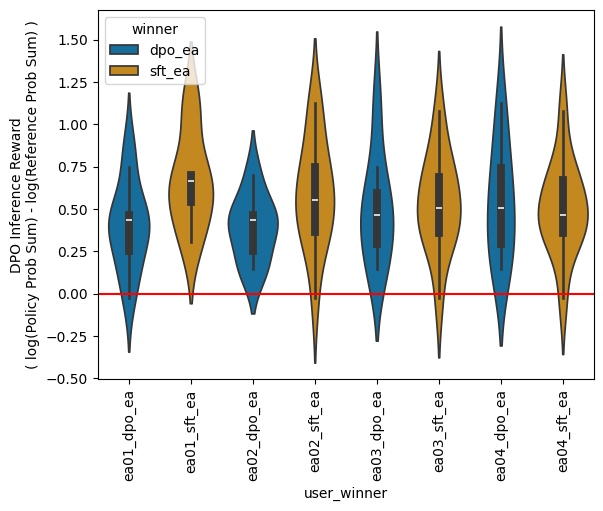

In [142]:
import seaborn as sns; import matplotlib.pyplot as plt
tmp['user_winner'] = tmp['userID'] + '_' + tmp['winner']
tmp['id_int'] = tmp['id'].astype(int)
tmp2 = tmp[tmp['id_int'] <= 3]
tmp2 = tmp2[tmp2['backbone'] == 'llama']
tmp2 = tmp2.sort_values('user_winner')
sns.violinplot(x='user_winner', y='pol_m_ref_logps', data=tmp2[tmp2['userID'].str.contains('ea')], palette="colorblind", hue='winner')
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('DPO Inference Reward\n( log(Policy Prob Sum) - log(Reference Prob Sum) )')

plt.show()